<a href="https://colab.research.google.com/github/Ssp24-1/CFD-Solvers/blob/main/VLM_CFD_Code_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total Lift(N): 46.14 N
Lift Coefficient: 0.379731


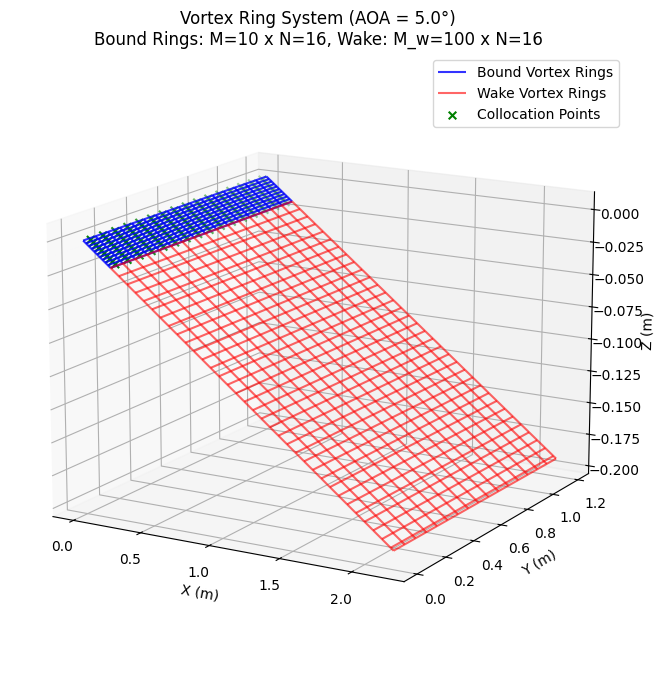

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Greek symbols: Α α Β β Γ γ Δ δ Ε ε Ζ ζ Η η Θ θ Ι ι Κ κ Λ λ Μ μ Ν ν Ξ ξ Ο ο Π π Ρ ρ Σ σ Τ τ Υ υ Φ φ Χ χ Ψ ψ Ω ω
# Subscripts: ₀ ₁ ₂ ₃ ₄ ₅ ₆ ₇ ₈ ₉ ₐ ₑ ᵢ ⱼ ₖ ₗ ₘ ₙ ₒ ₚ ᵣ ₛ ₜ ᵤ ᵥ ₓ
# Superscripts: ⁰ ¹ ² ³ ⁴ ⁵ ⁶ ⁷ ⁸ ⁹ ⁺ ⁻ ⁼ ⁽ ⁾
# Math Symbols: ∞ ∅ ∈ ∉ ⊂ ⊆ ∪ ∩ × · ÷ ± ≤ ≥ ≠ ≈ ≡ → ← ↑ ↓ ∇ ∂


# ===================== Functions =============================== #

def discretize(M, N, M_w, chord, span):
    """
    Discretizes wing geometry with bound vortex panels of MxN
    Discretization also includes the wake of the wing.

        Parameters:
        M : Chordwise Discretization Panels (int)
        N : Spanwise Discretization Panels (int)
        M_w : Chordwise Wake Panels (int)

        For this example, the chordwise spacing is constant and spanwise spacing is constant.

        Returns:
        Array with coordinates of all the panels (wing + wake), split into 2 arrays
    """
    x_vk = []
    y_vk = []
    z_vk = []

    x_wk = []
    y_wk = []
    z_wk = []

    #Chordwise Spacing (Constant Spacing) (Bound Vortex Rings)
    x_vk = np.linspace((chord/M)/4, chord + (chord/M)/4, M+1)
    x_vk = np.round(x_vk, 10)

    #Spanwise Spacing (Constant Spacing) (Bound Vortex Rings)
    y_vk = np.linspace(0, span, N+1)
    y_vk = np.round(y_vk, 10)

    z_vk = np.zeros_like(x_vk)
    z_vk = np.round(z_vk, 10)


    #Spanwise Spacing (Cosine Spacing) (Bound Vortex Rings)
    # y_vk = np.array([(0.5 * (1 - np.cos(np.pi * j / N)) * span) for j in range(0, N+1)])

    # Chordwise Spacing (Wake Vortex Rings)
    x_wk = np.linspace(chord + (chord/M)/4, (chord + (chord/M)/4 + M*chord), M_w+1)
    x_wk = np.round(x_wk, 10)


    #Spanwise Spacing (Bound Vortex Rings)
    y_wk = y_vk
    y_wk = np.round(y_wk, 10)


    z_wk = np.zeros_like(x_wk)
    z_wk = np.round(z_wk, 10)



    return x_vk, y_vk, z_vk, x_wk, y_wk, z_wk


def discretize_geo(M, N, chord, span):
    """
    Discretizes wing geometry into geometric panels
    On these panels, the bound vortex ring is attached at c/4 of each panel.

        Parameters:
        M : Chordwise Discretization Panels (int)
        N : Spanwise Discretization Panels (int)
        M_w : Chordwise Wake Panels (int)

        For this example, the chordwise spacing is constant and spanwise spacing is constant.

        Returns:
        Array with coordinates of all the panels
    """
    x_geo = []
    y_geo = []
    z_geo = []

    x_col = []
    y_col = []
    z_col = []

    #Chordwise Spacing (Constant Spacing) (Bound Vortex Rings)
    x_geo = np.linspace(0, chord, M+1)

    #Spanwise Spacing (Constant Spacing) (Bound Vortex Rings)
    y_geo = np.linspace(0, span, N+1)

    z_geo = np.zeros_like(x_geo)


    x_col = np.linspace(3*(chord/M)/4, chord - (chord/M)/4, M)
    x_col = np.round(x_col, 10)

    y_col = np.linspace((span/N)/2,  span - (span/N)/2, N)
    y_col = np.round(y_col, 10)


    z_col = z_geo
    z_col = np.round(z_col, 10)


    return x_geo, y_geo, z_geo, x_col, y_col, z_col


def panel(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4):
    """
    Collects geometric information of each panel:

        1. Panel Area
        2. Normal Vector of Panel
    """

    # Panel Area - Calculate using cross product for accurate area
    # Vector from point 1 to point 3 (diagonal)
    vec1 = np.array([x3 - x1, y3 - y1, z3 - z1])
    # Vector from point 2 to point 4 (diagonal)
    vec2 = np.array([x4 - x2, y4 - y2, z4 - z2])

    # Area of quadrilateral = 0.5 * |cross product of diagonals|
    cross_product = np.cross(vec1, vec2)
    S = 0.5 * np.linalg.norm(cross_product)

    # Round to remove machine precision errors
    S = round(S, 10)


    # Normal Vector of Panel
    # Use cross product of diagonals: (Point1 → Point3) × (Point2 → Point4)
    # This gives the normal vector to the panel

    A1 = x3 - x1  # Point 1 to Point 3
    A2 = y3 - y1
    A3 = z3 - z1

    B1 = x4 - x2  # Point 2 to Point 4
    B2 = y4 - y2
    B3 = z4 - z2

    # Cross product A × B gives normal vector
    X = A2*B3 - A3*B2
    Y = A3*B1 - A1*B3
    Z = A1*B2 - A2*B1

    Denom = (X**2 + Y**2 + Z**2)**0.5

    NX = X/Denom
    NY = Y/Denom
    NZ = Z/Denom


    return S, NX, NY, NZ



def VORTXL(x, y, z, x1, y1, z1, x2, y2, z2, gamma):
    """
    Function to calculate the induced velocities [u, v, w] due to a vortex filament,
    whose end points are given by (x1, y1, z1) and (x2, y2, z2)
    using the Biot-Savart law.

        ** Here z1 = z2 = 0.0 (Thin Uncambered airfoil)
    """

    # Vector from field point to filament endpoints
    r1 = np.array([x - x1, y - y1, z - z1])  # Vector from point 1 to field point
    r2 = np.array([x - x2, y - y2, z - z2])  # Vector from point 2 to field point

    # Cross product r1 × r2
    r1_cross_r2 = np.cross(r1, r2)
    r1_cross_r2_mod_squared = np.dot(r1_cross_r2, r1_cross_r2)  # |r1 × r2|²

    # Magnitudes of r1 and r2
    r1_mod = np.linalg.norm(r1)
    r2_mod = np.linalg.norm(r2)

    # Filament direction vector
    r0 = np.array([x2 - x1, y2 - y1, z2 - z1])  # From point 1 to point 2

    # Dot products for the geometric factor
    r0_dot_r1 = np.dot(r0, r1)
    r0_dot_r2 = np.dot(r0, r2)

    # Biot-Savart law: velocity = (Γ/4π) * (r1xr2)/|r1xr2|² * (r0·r1/|r1| - r0·r2/|r2|)
    # Check for singularity (If distance is too close to the filament)
    if r1_cross_r2_mod_squared < 1e-12 or r1_mod < 1e-12 or r2_mod < 1e-12:
        return 0.0, 0.0, 0.0

    K = (gamma / (4 * np.pi * r1_cross_r2_mod_squared)) * (r0_dot_r1/r1_mod - r0_dot_r2/r2_mod)

    # Induced velocity vector
    velocity = K * r1_cross_r2

    return velocity[0], velocity[1], velocity[2]



def VORING(x, y, z, vr_points, i, j, gamma_ij):
    """
    Function to calculate the induced velocities [u, v, w] due to a vortex ring,
    consisting of 4 vortex filaments.

    Here, each vortex ring is identified with i, j indices:
        Points of vortex ring:
            1. vr_points[i][j]
            2. vr_points[i][j+1]
            3. vr_points[i+1][j+1]
            4. vr_points[i+1][j]

            1 ------- 2
            |         |
            |         |
            4 ------- 3
    """

    # Individual Filament induced velocities
    u1, v1, w1 = VORTXL(x, y, z, vr_points[i][j][0], vr_points[i][j][1], vr_points[i][j][2],
                         vr_points[i][j+1][0], vr_points[i][j+1][1], vr_points[i][j+1][2], gamma_ij)

    u2, v2, w2 = VORTXL(x, y, z, vr_points[i][j+1][0], vr_points[i][j+1][1], vr_points[i][j+1][2],
                         vr_points[i+1][j+1][0], vr_points[i+1][j+1][1], vr_points[i+1][j+1][2], gamma_ij)

    u3, v3, w3 = VORTXL(x, y, z, vr_points[i+1][j+1][0], vr_points[i+1][j+1][1], vr_points[i+1][j+1][2],
                         vr_points[i+1][j][0], vr_points[i+1][j][1], vr_points[i+1][j][2], gamma_ij)

    u4, v4, w4 = VORTXL(x, y, z, vr_points[i+1][j][0], vr_points[i+1][j][1], vr_points[i+1][j][2],
                         vr_points[i][j][0], vr_points[i][j][1], vr_points[i][j][2], gamma_ij)

    # Total Sum of Induced Velocities
    u = u1+ u2 + u3 + u4
    v = v1+ v2 + v3 + v4
    w = w1+ w2 + w3 + w4

    # Return as a single vector [u, v, w]
    return np.array([u, v, w])




# ================================= Main ================================= #
chord = 0.2 # Chord length of the wing (m)
span = 1.2 # Span length of the wing (m)
M = 10 # Number of chordwise panels
N = 16 # Number of spanwise panels
M_w = 100 # Number of chordwise wake panels
U = 30 # Freestream Velocity
AOA_deg = 5.0
density = 1.125

AOA = np.deg2rad(AOA_deg) # Angle of Attack (5 degrees in radians)

U_vec = [U, 0, 0]  # Horizontal freestream (wing rotates instead of flow)

x_g, y_g, z_g, col_x, col_y, col_z = discretize_geo(M, N, chord, span)               # Geometric Discretization
x, y, z, x_w, y_w, z_w = discretize(M, N, M_w, chord, span)                          # Vortex Ring Discretization


# Create 2D Array of all Geometric Panel Points
# For each x, go through all y, z values, then move to next x
geo_points = []

for i in range(0, M+1):
    row = []
    for j in range(0, N+1):
        # Original coordinates (wing at AOA = 0)
        x_orig = x_g[i]
        y_orig = y_g[j]
        z_orig = z_g[i]

        # Rotate coordinates by angle of attack about Y-axis
        # Rotation matrix about Y-axis: [[cos(θ), 0, sin(θ)], [0, 1, 0], [-sin(θ), 0, cos(θ)]]
        x_rot = x_orig * np.cos(AOA) + z_orig * np.sin(AOA)
        y_rot = y_orig  # Y unchanged
        z_rot = -x_orig * np.sin(AOA) + z_orig * np.cos(AOA)

        row.append([x_rot, y_rot, z_rot])
    geo_points.append(row)


# Create 2D Array of all Bound Vortex Ring End Points
# For each x, go through all y, z values, then move to next x
vr_points = []

for i in range(0, M+1):
    row = []
    for j in range(0, N+1):
        # Original coordinates (wing at AOA = 0)
        x_orig = x[i]
        y_orig = y[j]
        z_orig = z[i]

        # Rotate coordinates by angle of attack about Y-axis
        # Rotation matrix about Y-axis: [[cos(θ), 0, sin(θ)], [0, 1, 0], [-sin(θ), 0, cos(θ)]]
        x_rot = x_orig * np.cos(AOA) + z_orig * np.sin(AOA)
        y_rot = y_orig  # Y unchanged
        z_rot = -x_orig * np.sin(AOA) + z_orig * np.cos(AOA)

        row.append([x_rot, y_rot, z_rot])
    vr_points.append(row)


vr_points = np.array(vr_points)

# Create 2D Array of Wake Vortex Ring End Points
# Wake extends downstream from trailing edge
wake_points = []

for i in range(0, M_w+1):
    row = []
    for j in range(0, N+1):
        # Original coordinates (wake at AOA = 0)
        x_orig = x_w[i]
        y_orig = y_w[j]
        z_orig = z_w[i]

        # Rotate coordinates by angle of attack about Y-axis
        # Rotation matrix about Y-axis: [[cos(θ), 0, sin(θ)], [0, 1, 0], [-sin(θ), 0, cos(θ)]]
        x_rot = x_orig * np.cos(AOA) + z_orig * np.sin(AOA)
        y_rot = y_orig  # Y unchanged
        z_rot = -x_orig * np.sin(AOA) + z_orig * np.cos(AOA)

        row.append([x_rot, y_rot, z_rot])
    wake_points.append(row)


wake_points = np.array(wake_points)


S_panel = []
norm_vec_x = []
norm_vec_y = []
norm_vec_z = []

for i in range(0, M):
    for j in range(0, N):
        # Get the 4 corner points of the vortex ring
        # Point 1: vr_points[i][j]
        x1, y1, z1 = vr_points[i][j][0], vr_points[i][j][1], vr_points[i][j][2]

        # Point 2: vr_points[i][j+1]
        x2, y2, z2 = vr_points[i][j+1][0], vr_points[i][j+1][1], vr_points[i][j+1][2]

        # Point 3: vr_points[i+1][j+1]
        x3, y3, z3 = vr_points[i+1][j+1][0], vr_points[i+1][j+1][1], vr_points[i+1][j+1][2]

        # Point 4: vr_points[i+1][j]
        x4, y4, z4 = vr_points[i+1][j][0], vr_points[i+1][j][1], vr_points[i+1][j][2]

        # Call panel function to get geometric properties
        S, NX, NY, NZ = panel(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)

        # Store the results
        S_panel.append(S)
        norm_vec_x.append(NX)
        norm_vec_y.append(NY)
        norm_vec_z.append(NZ)


# Normal Vector
norm_vec = []

for i in range(0, M):
    row = []
    for j in range(0, N):
        row.append([norm_vec_x[(N-1)*i+j], norm_vec_y[(N-1)*i+j], norm_vec_z[(N-1)*i+j]])
    norm_vec.append(row)


# Create 2D Array of all Collocation Points
col_points = []

for i in range(0, M):
    row = []
    for j in range(0, N):
        # Original coordinates (wing at AOA = 0)
        x_orig = col_x[i]
        y_orig = col_y[j]
        z_orig = col_z[i]

        # Rotate coordinates by angle of attack about Y-axis
        # Rotation matrix about Y-axis: [[cos(θ), 0, sin(θ)], [0, 1, 0], [-sin(θ), 0, cos(θ)]]
        x_rot = x_orig * np.cos(AOA) + z_orig * np.sin(AOA)
        y_rot = y_orig  # Y unchanged
        z_rot = -x_orig * np.sin(AOA) + z_orig * np.cos(AOA)

        row.append([x_rot, y_rot, z_rot])
    col_points.append(row)

col_points = np.array(col_points)



# ================ Influence Coefficient Calculation ======================= #
"""
    To obtain the influence coefficient of each panel, the induced velocities are calculated
    with the strength of each vortex filament of all vortex rings = 1.0.

    The influence coefficient will be the dot product of the induced velocity and normal vector
    of each corresponding panel.

    For VLM with Kutta condition, we need:
    - Influence of bound vortex rings (unknown strengths) -> A-matrix
    - Influence of wake vortex rings (known strengths = trailing edge) -> W-matrix

    The wake strengths are determined by Kutta condition:
    Γ_wake[i,j] = Γ_bound[M-1,j] (last row of bound rings)
"""

# Initialize arrays to store influence coefficients
A_matrix = np.zeros((M*N, M*N))  # Influence coefficient matrix for bound vortex rings
W_matrix = np.zeros((M*N, N))    # Wake influence matrix (each wake row has N rings)

# Calculate influence of bound vortex rings on collocation points
for i in range(0, M):
    for j in range(0, N):

        # Bound vortex ring influences (unknown strengths -> A-matrix)
        for i_vr in range(0, M):  # Loop through bound vortex rings
            for j_vr in range(0, N):

                # Calculate induced velocity at collocation point due to bound vortex ring with unit strength
                [u, v, w] = VORING(col_points[i][j][0], col_points[i][j][1], col_points[i][j][2], vr_points, i_vr, j_vr, 1.0)

                # Calculate influence coefficient (dot product with normal vector)
                n_vec = norm_vec[i][j]
                influence_coeff = u * n_vec[0] + v * n_vec[1] + w * n_vec[2]
                A_matrix[i*N + j, i_vr*N + j_vr] = influence_coeff

        # Wake vortex ring influences (known strengths from Kutta condition)
        """
                Here, the constant strength implementation is followed for all vortex rings. So all vortex rings will have the same strength

                To satisfy the Kutta condition, Strength of 1st row of wake vortex rings = Strength of trailing edge bound vortex rings.
                So automatically, all the wake vortex ring's strengths will be known.
        """
        # Each wake ring [i_w, j_w] has strength = trailing edge bound ring [M-1, j_w]
        for j_w in range(0, N):
            total_wake_influence = 0.0


            for i_w in range(0, M_w):  # All wake rows
                [u_w, v_w, w_w] = VORING(col_points[i][j][0], col_points[i][j][1], col_points[i][j][2], wake_points, i_w, j_w, 1.0)

                n_vec = norm_vec[i][j]
                wake_influence_coeff = u_w * n_vec[0] + v_w * n_vec[1] + w_w * n_vec[2]
                total_wake_influence += wake_influence_coeff

            W_matrix[i*N + j, j_w] = total_wake_influence



# ============== Gamma (Strength) Calculation with Kutta Condition ===================== #
"""
    The system with Kutta condition becomes:

    [A] * {Γ} + [W] * {Γ_trailing_edge} = {RHS}

    Where Γ_trailing_edge = Γ[M-1, :] (last row of bound vortex strengths)

    Since all the strengths of the rings in the chordwise direction for each span location from the Trailing Edge to
    end of the wake are having the same strength, we just have to add the corresponding columns of influence coefficients
    of the wake to the training edge bound coefficients.
"""

# Build RHS Vector (freestream influence only)
RHS_vector = np.zeros(M*N)

for i in range(0, M):  # Loop through collocation points
    for j in range(0, N):

        n_vec = norm_vec[i][j]
        dot_vel = -U_vec[0] * n_vec[0] - U_vec[1] * n_vec[1] - U_vec[2] * n_vec[2]

        RHS_vector[i*N + j] = dot_vel

# Add the influence of wake into A-Matrix
for i in range(0, M):
    for j in range(0, N):
        for j_w in range(0, N):
            A_matrix[i*N + j, (M-1)*N + j_w] += W_matrix[i*N + j, j_w]



# ===================== Solve For Gamma (Strength) ============================ #

# Solve the system to get strengths of all vortex rings
gamma = np.linalg.solve(A_matrix, RHS_vector)

# Convert 1D gamma to 2D array (M x N)
gamma_2D = []
for i in range(0, M):
    row = []
    for j in range(0, N):
        row.append(gamma[N*i + j])
    gamma_2D.append(row)

gamma_2D = np.array(gamma_2D)



# # ================ Secondary Computations ================== #

del_y_ij = span/N
total_lift = 0

for i in range(0, M):  # Loop through vortex rings
    for j in range(0, N):
        vr_index = i * N + j  # Linear index for vortex ring
        if i == 0:
            total_lift = total_lift + (density * U * gamma_2D[i][j] * del_y_ij)
        else:
            total_lift = total_lift + (density * U * (gamma_2D[i][j] - gamma_2D[i-1][j]) * del_y_ij)

print(f"Total Lift(N): {total_lift:.2f} N")

Cl = total_lift / (0.5 * density * chord * span * U**2)
print(f"Lift Coefficient: {Cl:.6f}")



# =========================== (Plotting) ========================= #

# Create wireframe plot of geometric points
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates for bound vortex ring wireframe plotting
X_vr = vr_points[:, :, 0]  # X coordinates of bound vortex rings (M+1 x N+1)
Y_vr = vr_points[:, :, 1]  # Y coordinates
Z_vr = vr_points[:, :, 2]  # Z coordinates

# Create wireframe plot for bound vortex rings (wing)
wireframe_vr = ax.plot_wireframe(X_vr, Y_vr, Z_vr, color='blue', alpha=0.8, linewidth=1.5, label='Bound Vortex Rings')

# Extract coordinates for wake vortex ring wireframe plotting
X_wake = wake_points[:, :, 0]  # X coordinates of wake vortex rings (M_w+1 x N+1)
Y_wake = wake_points[:, :, 1]  # Y coordinates
Z_wake = wake_points[:, :, 2]  # Z coordinates

# Create wireframe plot for wake vortex rings
wireframe_wake = ax.plot_wireframe(X_wake, Y_wake, Z_wake, color='red', alpha=0.6, linewidth=1.5, label='Wake Vortex Rings')

# Plot collocation points for reference
col_x_plot = col_points[:, :, 0].flatten()
col_y_plot = col_points[:, :, 1].flatten()
col_z_plot = col_points[:, :, 2].flatten()
ax.scatter(col_x_plot, col_y_plot, col_z_plot, color='green', s=30, marker='x', label='Collocation Points')

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title(f'Vortex Ring System (AOA = {AOA_deg}°)\nBound Rings: M={M} x N={N}, Wake: M_w={M_w} x N={N}')

# Set viewing angle for better visualization of wing and wake
ax.view_init(elev=15, azim=-60)

# Add legend
ax.legend()

# Add grid
ax.grid(True, alpha=0.3)

# Show the plot
plt.show()